# ETDataset: ETTh1

**Dataset Link:** https://github.com/zhouhaoyi/ETDataset/blob/main/ETT-small/ETTh1.csv

### 1. Environment set-up

1. This notebook contains elements which render correctly in Jupyter interface. Open this notebook from an Amazon SageMaker Notebook Instance or Amazon SageMaker Studio.
1. Ensure that IAM role used has **AmazonSageMakerFullAccess**
1. Some hands-on experience using [Amazon SageMaker](https://aws.amazon.com/sagemaker/).
1. To use this algorithm successfully, ensure that:
    1. Either your IAM role has these three permissions and you have authority to make AWS Marketplace subscriptions in the AWS account used: 
        1. **aws-marketplace:ViewSubscriptions**
        1. **aws-marketplace:Unsubscribe**
        1. **aws-marketplace:Subscribe**  
    2. or your AWS account has a subscription to the [Time Series Forecasting (CfC) Algorithm from AWS Marketplace](placeholder).

To subscribe to the algorithm:
1. Open the algorithm listing page.
1. On the AWS Marketplace listing, click on the **Continue to subscribe** button.
1. On the **Subscribe to this software** page, review and click on **"Accept Offer"** if you agree with EULA, pricing, and support terms. 
1. Once you click on the **Continue to configuration** button and then choose a **region**, you will see a **Product ARN**. This is the algorithm ARN that you need to specify while training a custom ML model. **Copy the ARN corresponding to your region and specify the same in the following cell.**

In [1]:
algo_arn = "arn:aws:sagemaker:eu-west-1:661670223746:algorithm/cfc-tsf-algo-v1-1"

In [2]:
import sagemaker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# SageMaker session
sagemaker_session = sagemaker.Session()

# SageMaker role
role = sagemaker.get_execution_role()

# S3 bucket
bucket = sagemaker_session.default_bucket()

# EC2 instance
instance_type = "ml.m5.2xlarge"

### 2. Data preparation

Load the data.

In [3]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv",
    parse_dates=["date"]
)

In [4]:
df.shape

(17420, 8)

In [5]:
df.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


In [6]:
df.tail()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
17415,2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,10.904
17416,2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,11.044
17417,2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,10.271
17418,2018-06-26 18:00:00,9.243,3.818,5.472,2.097,3.655,1.432,9.778
17419,2018-06-26 19:00:00,10.114,3.550,6.183,1.564,3.716,1.462,9.567


In [7]:
df["date"].diff().describe()

count              17419
mean     0 days 01:00:00
std      0 days 00:00:00
min      0 days 01:00:00
25%      0 days 01:00:00
50%      0 days 01:00:00
75%      0 days 01:00:00
max      0 days 01:00:00
Name: date, dtype: object

Visualize the data.

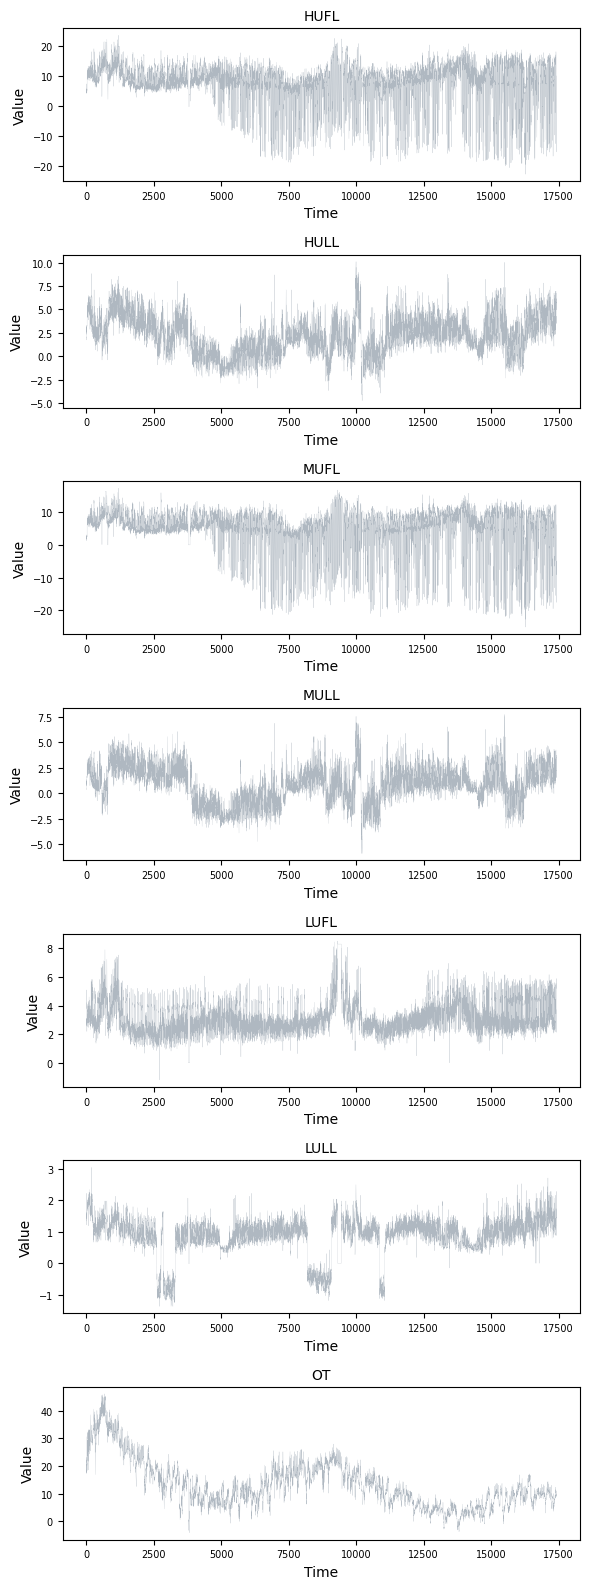

In [8]:
fig, axs = plt.subplots(nrows=len([c for c in df.columns if c != "date"]), ncols=1, sharex=True, figsize=(6, 16))
for i, c in enumerate([c for c in df.columns if c != "date"]):
    axs[i].plot(df[c], color="#AFB8C1", lw=0.15)
    axs[i].set_title(c, size=10)
    axs[i].set(xlabel="Time", ylabel="Value")
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis="both", which="major", labelsize=7)
    axs[i].tick_params(axis="both", which="minor", labelsize=7)
fig.tight_layout()
fig.show()

Prepare the data.

In [9]:
dataset = df.rename(columns={
    "date": "ts",
    "HUFL": "x1",
    "HULL": "x2",
    "MUFL": "x3",
    "MULL": "x4",
    "LUFL": "x5",
    "LULL": "x6",
    "OT": "y",
})

dataset["ts"] = dataset["ts"].diff().dt.seconds.fillna(value=0) // 3600

dataset.head()

,ts,x1,x2,x3,x4,x5,x6,y
0,0.0,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,1.0,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,1.0,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,1.0,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,1.0,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


Split the data.

In [10]:
cutoff = 4 * 30 * 24 
training_dataset = dataset.iloc[:- cutoff]
test_dataset = dataset.iloc[- cutoff:]

Upload the data to S3.

In [11]:
training_data = sagemaker_session.upload_string_as_file_body(
    body=training_dataset.to_csv(index=False),
    bucket=bucket,
    key="ETTh1_train.csv"
)

In [12]:
training_data

's3://sagemaker-eu-west-1-661670223746/ETTh1_train.csv'

In [13]:
test_data = sagemaker_session.upload_string_as_file_body(
    body=test_dataset.to_csv(index=False),
    bucket=bucket,
    key="ETTh1_test.csv"
)

In [14]:
test_data

's3://sagemaker-eu-west-1-661670223746/ETTh1_test.csv'

### 3. Training

Fit the model to the training set.

In [15]:
context_length = 48     # number of timesteps used as input 
prediction_length = 24  # number of timesteps to output

In [16]:
estimator = sagemaker.algorithm.AlgorithmEstimator(
    algorithm_arn=algo_arn,
    role=role,
    instance_count=1,
    instance_type=instance_type,
    input_mode="File",
    sagemaker_session=sagemaker_session,
    hyperparameters={
        "context-length": context_length,
        "prediction-length": prediction_length,
        "backbone-layers": 1,
        "backbone-units": 128,
        "backbone-activation": "silu",
        "backbone-dropout": 0,
        "hidden-size": 64,
        "minimal": 0,
        "no-gate": 0,
        "use-ltc": 0,
        "use-mixed": 0,
        "lr": 0.001,
        "lr-decay": 0.9,
        "batch-size": 64,
        "epochs": 50,
    },
)

estimator.fit({"training": training_data})

INFO:sagemaker:Creating training-job with name: cfc-tsf-algo-v1-1-2023-09-07-12-57-47-959


2023-09-07 12:57:48 Starting - Starting the training job...
2023-09-07 12:58:02 Starting - Preparing the instances for training......
2023-09-07 12:58:52 Downloading - Downloading input data...............
2023-09-07 13:01:47 Training - Downloading the training image......
2023-09-07 13:02:28 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-09-07 13:03:04,257 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-09-07 13:03:04,257 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-09-07 13:03:04,258 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-09-07 13:03:04,258 sagemaker-training-toolkit INFO     Failed to parse hyperparameter backbone-activation value silu to Json.
Returning the value itself
2023-09-07 13:03:04,267 sagemak

### 4. Inference

Generate the test set predictions.

In [17]:
transformer = estimator.transformer(
    instance_count=1,
    instance_type=instance_type,
    max_payload=100,
)

transformer.transform(
    data=test_data,
    content_type="text/csv",
)

INFO:sagemaker:Creating model package with name: cfc-tsf-algo-v1-1-2023-09-07-13-16-22-027


.........

INFO:sagemaker:Creating model with name: cfc-tsf-algo-v1-1-2023-09-07-13-16-22-0-2023-09-07-13-17-07-558


INFO:sagemaker:Creating transform job with name: cfc-tsf-algo-v1-1-2023-09-07-13-17-08-269


..........................................
2023-09-07T13:24:06,511 [INFO ] main org.pytorch.serve.servingsdk.impl.PluginsManager - Initializing plugins manager...
2023-09-07T13:24:06,574 [INFO ] main org.pytorch.serve.metrics.configuration.MetricConfiguration - Successfully loaded metrics configuration from /opt/conda/lib/python3.10/site-packages/ts/configs/metrics.yaml
2023-09-07T13:24:06,673 [INFO ] main org.pytorch.serve.ModelServer - 
2023-09-07T13:24:06,511 [INFO ] main org.pytorch.serve.servingsdk.impl.PluginsManager - Initializing plugins manager...
2023-09-07T13:24:06,574 [INFO ] main org.pytorch.serve.metrics.configuration.MetricConfiguration - Successfully loaded metrics configuration from /opt/conda/lib/python3.10/site-packages/ts/configs/metrics.yaml
2023-09-07T13:24:06,673 [INFO ] main org.pytorch.serve.ModelServer - 
Torchserve version: 0.8.1
TS Home: /opt/conda/lib/python3.10/site-packages
Current directory: /
Temp directory: /home/model-server/tmp
Metrics config path: /

Load the test set predictions from S3.

In [18]:
predictions = sagemaker_session.read_s3_file(
    bucket=bucket,
    key_prefix=f"{transformer.latest_transform_job.name}/ETTh1_test.csv.out"
)

predictions = predictions.split("\n")[:-1]
predictions = pd.DataFrame(data=predictions[1:], columns=predictions[:1]).replace('""', np.nan).astype(float)

In [19]:
predictions.shape

(2904, 1)

In [20]:
predictions.head()

,y
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


In [21]:
predictions.tail()

,y
2899,9.991552
2900,9.419144
2901,9.397604
2902,9.181594
2903,9.151226


Visualize the test set predictions.

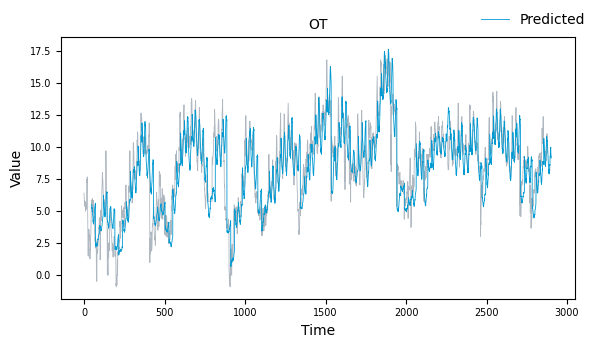

In [22]:
fig, ax = plt.subplots(figsize=(6, 3.5))
ax.set_title("OT", size=10)
ax.plot(test_dataset["y"].values, color="#AFB8C1", lw=0.6)
ax.plot(predictions["y"].values, color="#009ad3", lw=0.6, label="Predicted")
ax.set(xlabel="Time", ylabel="Value")
ax.tick_params(axis="both", which="major", labelsize=7)
ax.tick_params(axis="both", which="minor", labelsize=7)
fig.legend(frameon=False)
fig.tight_layout()
fig.show()

Calculate the error metrics.

In [23]:
mse = mean_squared_error(
    test_dataset["y"].iloc[context_length:], 
    predictions["y"].iloc[context_length: - prediction_length]
)

mae = mean_absolute_error(
    test_dataset["y"].iloc[context_length:], 
    predictions["y"].iloc[context_length: -prediction_length]
)

print(f"MSE: {format(mse, '.2f')}, MAE: {format(mae, '.2f')}")

MSE: 3.27, MAE: 1.32
